# Setup
This section contains all codes and presets to setup the notebook.

In [2]:
# Reload all modules at every code execution
%load_ext autoreload
%autoreload 2

In [3]:
# Dataloader
from thenetflixstory.data_processing import load_netflixdata
df_netflix = load_netflixdata()

In [16]:
# Default Format presets
BAR_FORMATS = {'highlight':{'color':'red'},
          'deemphasize':{'color':'lightgrey'}
          }

FIGURE_FORMATS = {'figsize':(12,6)}

<p align="center">
  <img src="pics/netflix_intro_logo.avif" width="800">
  <br>
  <em>Image: From Thibault Penin on https://unsplash.com/</em>
</p>

# Netflix Unfiltered - What Content Ratings and Genres Reveal About the Platform's Evolution

## Intro - Our Research Question
Over the years, Netflix has shifted from a family-friendly catalog to a platform dominated by mature content. We explore how content rating, genre, country, and format changed - and what this reveals about its evolving strategy.

TODO: Set expectations (what trends or questions will be explored -> Lead)

## Explain the data source (Netflix dataset)
TODO... 

## Graph1 (Sven) - Growth by Age Rating
Shows how TV-MA and R-related content exploted post-2015

## Graph2 (Sven) - Composition by Rating
Confirms the shift: mature content now dominates share.


## Graph3 (Sven) Genre vs Rating
Reveals that Drama, Thriller, HOrror = mature, Kids, Family = G/PG

## Graph4 (Boris) - Top Countries by Mature Titles
Which regions are leading to shift to TV-MA?

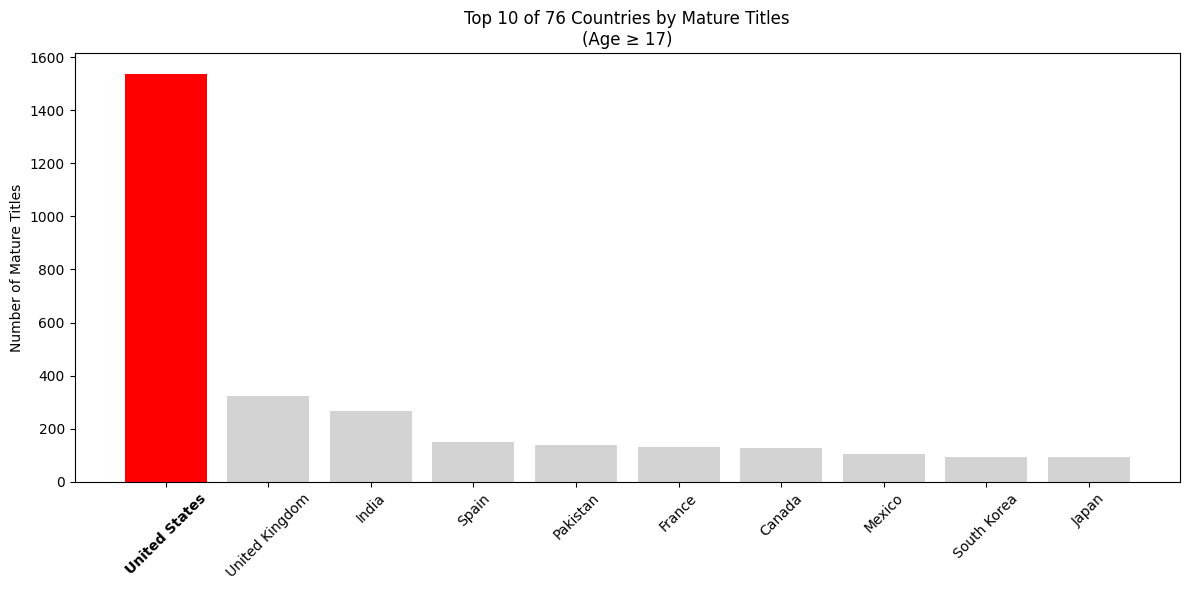

In [113]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- Mature-Filter ----
AGE_FILTER = 17
TOP_N_COUNTRIES = 10

df_mature = df_netflix.query('rating_age >= @AGE_FILTER')

# ---- Länder zählen ----
country_counts = (
    df_mature['country_clean']
    .value_counts()
    .head(TOP_N_COUNTRIES)  # Top 10
)

# ---- Farben definieren ----
colors = [BAR_FORMATS['highlight']['color']] + [BAR_FORMATS['deemphasize']['color']] * (len(country_counts) - 1)

# ---- Plot ----
fig, ax = plt.subplots(**FIGURE_FORMATS)
bars = ax.bar(country_counts.index, country_counts.values, color=colors)

# ---- Titel ----
total_n_countries = len(df_mature['country_clean'].unique())
ax.set_title(
    f"Top {TOP_N_COUNTRIES} of {total_n_countries} Countries by Mature Titles\n(Age ≥ {AGE_FILTER})"
)

ax.set_xlabel("")
ax.set_ylabel("Number of Mature Titles")
ax.tick_params(axis='x', rotation=45)

# ---- Top-Country Label fett machen ----
for tick_label in ax.get_xticklabels():
    if tick_label.get_text() == country_counts.index[0]:  # erstes Land
        tick_label.set_fontweight('bold')

plt.tight_layout()
plt.show()


### TODO: 4.1 Story
- Faden überlegen, wie Chart1 (ist effektiv ein Shift passiert? Ja) -> Chart4 (Einfluss pro Land auf Netflix) verknüpft werden kann
- USA hat Netflix contentmässig auf jeden Fall sehr stark beeinflusst im Bereich Mature-Content.
- Hypothese1: Gibt es in USA Ängste von Klagen je nach COntent oder sind USA einfach generell prüder?

In [109]:
import plotly.express as px

# Datensatz filtern
min_age = 17
df_mature = df_netflix.query('rating_age >= @min_age')
df_mature_exp = df_mature.explode('genres_list')

# Nur gültige Einträge
df_mature_exp = df_mature_exp.dropna(subset=["country", "genres_list"])

# Top-Land bestimmen
country_counts = df_mature_exp['country'].value_counts()
top_country = country_counts.index[0]
total_titles = country_counts.sum()

# Anteil berechnen
country_percent = (country_counts / total_titles * 100).round(1)

# Optional: neues Label mit Anteil erstellen
df_mature_exp['country_label'] = df_mature_exp['country'].apply(
    lambda c: f"{c} ({country_percent[c]}%)" if c in country_percent else c
)

# Farbdict erstellen
color_map = {c: "rgb(220,0,0)" if c == top_country else "rgb(180,180,180)"
             for c in df_mature_exp["country"].unique()}

fig = px.treemap(
    df_mature_exp,
    path=["country_label", "genres_list"],
    color="country",
    color_discrete_map=color_map,
    title=f"Mature Titles Per Country (min. age > {min_age} years old)"
)

# Top-Country fett darstellen
fig.update_traces(
    texttemplate="%{label}",  # Label bleibt gleich
    selector=dict(type='treemap')
)

# Labels fett für das Top-Country
# Dazu kann man in df_mature_exp ein spezielles HTML-Tag verwenden
df_mature_exp['country_label_html'] = df_mature_exp['country_label'].apply(
    lambda x: f"<b>{x}</b>" if top_country in x else x
)

fig = px.treemap(
    df_mature_exp,
    path=["country_label_html", "genres_list"],
    color="country",
    color_discrete_map=color_map,
    title=f"Mature Titles Per Country (min. age ≥ {min_age} years old)"
)

fig.update_traces(
    textinfo="label+value+percent parent",
)

fig.show()


### Popcorn or Popporn?
Sucht man im Netflix-Datensatz nach dem Stichwort 'Sex', dann erscheinen total 18 Titel, allesamt untergebracht in harmlosen Genres wie Comedies, Dramas, Reality-TV usw. Der interessierte Leser wird an dieser Stelle darauf hingeweisen, dass es einen wesentlichen Unterschied zwischen "Mature Content" und "Adult Content" gibt. Letztere Kategorie scheint nicht der Netflix-Strategie zu entsprechen und wird interessanterweise überhaupt nicht angeboten.

### Auf anrüchiger Spur nach expliziter Sprache, Sex und Schwarzem Humor
Machen wir uns auf die Suche nach bekannten Titeln, die möglicherweise US-Mature-Content sind aber in FSK>18 durchgehen.
Die Suche nach oft zweideutigen Trickfilmen wie "South Park", aber auch "Deadpool" oder "The Wolf of Wall Street" sind in der Netflix-Datenbank gar nicht erst enthalten.

Eine kurze Suche nach verdächtigen Filmtiteln liefert uns dann folgende Treffer:
| Title                         | US-Rating (MAA)                  | FSK-Rating |
|-------------------------------|----------------------------------|------------|
| Zack and Miri Make a Porno    | R - Restricted Mature/Adult      | FSK-16     |
| American Pie 9: Girls' Rules  | R - Restricted Mature/Adult      | FSK-15     |
| Superbad                      | R - Restricted Mature/Adult      | FSK-16     |

*R = ab 17 Jahren, nur mit Eltern erlaubt


Damit wird ersichtlich, dass
a) einerseits die File in der Netfilx-Datenbank nach dem US-MAA klassifiziert werden, und nicht nach den regionalen Bewertungssystemen anderer Länder und
b) die USA zwar ein restriktiveres Bewertungssystem haben, im Widerspruch dazu aber trotzdem mehr Mature-Content produzieren als alle anderen Länder. Man könnte sagen: **geheuchelte Prüderie wird durch die Realität widerlegt.**


In [103]:
candidate_titles = [ #friendly provided by ChatGPT for this purpose
    "superbad",
    "40-year-old virgin",
    "40 year old virgin",
    "american pie",
    "wedding crashers",
    "knocked up",
    "hall pass",
    "forgetting sarah marshall",
    "zack and miri",
    "american wedding",
    "american pie 2"
]

pattern = "|".join(candidate_titles)

df_candidates = df_netflix[
    df_netflix['title']
    .str.lower()
    .str.contains(pattern, regex=True, na=False)
]
df_candidates[['title','rating','country']]

,title,rating,country
988,Zack and Miri Make a Porno,R,United States
1612,American Pie 9: Girls' Rules,R,United States
5974,Superbad,R,United States


### design
- Ggf. mehr Fokus auf etwas, das noch erst in der Story entdeckt wird?

### Story
- Es gibt Comedies, die als Mature gelten in den USA, was möglicherweise in Europa lächerlich wäre (verklagungen? Microwave-Hints)


In [100]:
import pandas as pd

# Flags
df = df_netflix.copy()

df['is_comedy'] = df['genres_list'].apply(
    lambda g: 'Comedies' in g if isinstance(g, list) else False
)

df['is_mature'] = df['rating_age'] >= 17
df['is_us'] = df['country_clean'] == 'United States'

# Descriptive statistics
summary = (
    df[df['is_comedy']]
    .groupby('is_us')['is_mature']
    .mean()
    .rename({True: 'United States', False: 'Other countries'})
)

summary_full = (
    df.groupby(['is_us', 'is_comedy'])['is_mature']
    .mean()
    .unstack()
    .rename(columns={True: 'Comedy', False: 'Non-Comedy'})
    .rename(index={True: 'United States', False: 'Other countries'})
)

summary_full


from scipy.stats import chi2_contingency

table = pd.crosstab(
    index=[df['is_us'], df['is_comedy']],
    columns=df['is_mature']
)

chi2, p, dof, expected = chi2_contingency(table)

chi2, p


(np.float64(74.7503208558567), np.float64(4.0984369499187936e-16))

In [104]:
summary_full

is_comedy,Non-Comedy,Comedy
is_us,,
Other countries,0.466607,0.351607
United States,0.494665,0.391234


In [111]:
df_netflix.query('rating_age >= 18')

,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in,duration_minutes,seasons,rating_description,rating_age,country_clean,ISO3_country,genres_list
3782,s5265,Movie,Swearnet: The Movie,Warren P. Sonoda,Canada,2017-09-24,2014,NC-17,112 min,"Comedies, International Movies",112,<NA>,"Nur Erwachsene, keine Zuschauer unter 18",18.0,Canada,CAN,"[Comedies, International Movies]"
4574,s6339,Movie,Blue Is the Warmest Color,Abdellatif Kechiche,France,2016-08-26,2013,NC-17,180 min,"Dramas, Independent Movies, International Movies",180,<NA>,"Nur Erwachsene, keine Zuschauer unter 18",18.0,France,FRA,"[Dramas, Independent Movies, International Mov..."
8533,s7264,Movie,Lady-Like,Not Given,United States,2019-01-18,2018,NC-17,83 min,"Comedies, Independent Movies",83,<NA>,"Nur Erwachsene, keine Zuschauer unter 18",18.0,United States,USA,"[Comedies, Independent Movies]"


In [114]:
pd.crosstab(df['country_clean'] == 'United States', df['rating'])


rating,G,NC-17,NR,PG,PG-13,R,TV-14,TV-G,TV-MA,TV-PG,TV-Y,TV-Y7,TV-Y7-FV,UR
country_clean,,,,,,,,,,,,,,
False,10,2,44,76,124,261,1712,132,2205,590,184,204,4,2
True,31,1,35,211,366,538,445,88,1000,271,122,129,2,1


## Graph5 (Boris) - Runtimes by Age Rating
Mature titles tend to be longer, especially TV shows.

## Graph6 (Elias) - Genre Popularity by Country
What genres are dominant in U.S., India, UK, Japan?

## TODO: Conclusion
a. Recap key Inisghts. Do not introduce new data - just synthesize
    
Zwischen 2010 und 2024 hat sich das Netflix-Angebot nicht nur mengenmäßig erweitert, sondern auch inhaltlich verändert. Die folgende Grafik zeigt die Entwicklung der Veröffentlichungen nach Altersfreigabe über die Jahre.
Bis etwa 2015 war die Verteilung relativ ausgewogen. Danach jedoch nimmt die Anzahl an Inhalten mit der Altersfreigabe TV-MA und R deutlich zu — parallel zur starken Zunahme an Eigenproduktionen.
Spätestens ab 2020 dominiert TV-MA das Angebot, während familienfreundliche Titel zahlenmäßig stagnieren.
Dieser Wandel ist Ausdruck einer gezielten Strategie: Netflix hat sich mit seinem Publikum weiterentwickelt. Der Chart legt damit das zeitliche Fundament für die folgenden Analysen zu Genre, Ländern und Content-Struktur.